# Using time to model a non-linear trend

In this notebook we show how to create a feature using time to capture the trend of a time series. We'll look at using powers of the time feature to create non-linear trends. We will use it to create some simple forecasts with a linear regression. 

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

In [3]:
# Let's work with pandas Period
data.index = data.index.to_period()

In [4]:
data.head()

,y
ds,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


## Plot the data

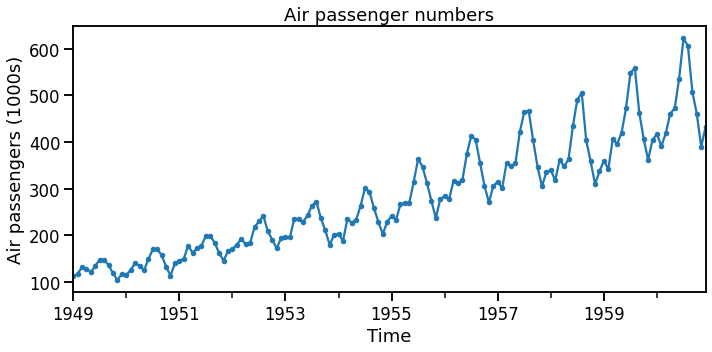

In [5]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# Let's create non-linear time features

Let's see how we can create these features with higher order terms such as $t^2$, $t^3$.

In [6]:
# Create a new copy of the original data.
df = data.copy()

Create the time feature (i.e., the time since the start of the time series).

In [7]:
# Requires version 0.14.1 or greater of sktime.
from sktime.transformations.series.time_since import TimeSince

In [8]:
time_since_transformer = TimeSince(keep_original_columns=True)

# Compute the time since the start of the time series
df = time_since_transformer.fit_transform(df)

df.head()

,y,time_since_1949-01
ds,,
1949-01,112,0
1949-02,118,1
1949-03,132,2
1949-04,129,3
1949-05,121,4


We could manually create these features.

In [9]:
df["t^2"] = df["time_since_1949-01"]**2

Alternatively, here is an example using the `PolynomialFeatures` transformer. By specifying `degree`, $d$, the transformer will output the following columns: $t$, $t^2$, ..., $t^d$.

In [10]:
from sklearn.preprocessing import PolynomialFeatures


In [11]:
# Create and use the polynomial transformer.
poly_transformer = PolynomialFeatures(degree=2, # degree of polynomial
                                      include_bias=False # exclude constant term
                                     )

# Create polynomial features from a given column
result = poly_transformer.fit_transform(df["time_since_1949-01"].to_frame())

result

array([[0.0000e+00, 0.0000e+00],
       [1.0000e+00, 1.0000e+00],
       [2.0000e+00, 4.0000e+00],
       [3.0000e+00, 9.0000e+00],
       [4.0000e+00, 1.6000e+01],
       [5.0000e+00, 2.5000e+01],
       [6.0000e+00, 3.6000e+01],
       [7.0000e+00, 4.9000e+01],
       [8.0000e+00, 6.4000e+01],
       [9.0000e+00, 8.1000e+01],
       [1.0000e+01, 1.0000e+02],
       [1.1000e+01, 1.2100e+02],
       [1.2000e+01, 1.4400e+02],
       [1.3000e+01, 1.6900e+02],
       [1.4000e+01, 1.9600e+02],
       [1.5000e+01, 2.2500e+02],
       [1.6000e+01, 2.5600e+02],
       [1.7000e+01, 2.8900e+02],
       [1.8000e+01, 3.2400e+02],
       [1.9000e+01, 3.6100e+02],
       [2.0000e+01, 4.0000e+02],
       [2.1000e+01, 4.4100e+02],
       [2.2000e+01, 4.8400e+02],
       [2.3000e+01, 5.2900e+02],
       [2.4000e+01, 5.7600e+02],
       [2.5000e+01, 6.2500e+02],
       [2.6000e+01, 6.7600e+02],
       [2.7000e+01, 7.2900e+02],
       [2.8000e+01, 7.8400e+02],
       [2.9000e+01, 8.4100e+02],
       [3.

Add the result to our dataframe

In [12]:
# Prepare column names for output dataframe.
df[["t^1", "t^2"]] = result

df.head()

,y,time_since_1949-01,t^2,t^1
ds,,,,
1949-01,112,0,0.0,0.0
1949-02,118,1,1.0,1.0
1949-03,132,2,4.0,2.0
1949-04,129,3,9.0,3.0
1949-05,121,4,16.0,4.0


Using a pipeline we can create these features in one go.

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
time_feats_pipe = Pipeline(
    [
    ('time', TimeSince()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ]
)

In [15]:
# Create a new copy of the original data.
df = data.copy()

In [16]:
result = time_feats_pipe.fit_transform(df)
result

array([[0.0000e+00, 0.0000e+00],
       [1.0000e+00, 1.0000e+00],
       [2.0000e+00, 4.0000e+00],
       [3.0000e+00, 9.0000e+00],
       [4.0000e+00, 1.6000e+01],
       [5.0000e+00, 2.5000e+01],
       [6.0000e+00, 3.6000e+01],
       [7.0000e+00, 4.9000e+01],
       [8.0000e+00, 6.4000e+01],
       [9.0000e+00, 8.1000e+01],
       [1.0000e+01, 1.0000e+02],
       [1.1000e+01, 1.2100e+02],
       [1.2000e+01, 1.4400e+02],
       [1.3000e+01, 1.6900e+02],
       [1.4000e+01, 1.9600e+02],
       [1.5000e+01, 2.2500e+02],
       [1.6000e+01, 2.5600e+02],
       [1.7000e+01, 2.8900e+02],
       [1.8000e+01, 3.2400e+02],
       [1.9000e+01, 3.6100e+02],
       [2.0000e+01, 4.0000e+02],
       [2.1000e+01, 4.4100e+02],
       [2.2000e+01, 4.8400e+02],
       [2.3000e+01, 5.2900e+02],
       [2.4000e+01, 5.7600e+02],
       [2.5000e+01, 6.2500e+02],
       [2.6000e+01, 6.7600e+02],
       [2.7000e+01, 7.2900e+02],
       [2.8000e+01, 7.8400e+02],
       [2.9000e+01, 8.4100e+02],
       [3.

In [17]:
df[["t^1", "t^2"]] = result
df.head()

,y,t^1,t^2
ds,,,
1949-01,112,0.0,0.0
1949-02,118,1.0,1.0
1949-03,132,2.0,4.0
1949-04,129,3.0,9.0
1949-05,121,4.0,16.0


# Let's build a forecast with just these non-linear time features.

As with the previous notebook, in this notebook we will focus more on the impact of these features rather than the overall forecasting workflow. We will show the creation of these features in a recursive forecasting workflow in the next notebook. We will see what impact using higher order terms such as $t^2$, $t^3$, and so on can have.

In [18]:
# Create a new copy of the original data.
df = data.copy()

Let's split the data into train and test.

In [19]:
holdout_size = 12*6 # forecast horizon

# Use all the time up until the start
# of the forecast horizon for training.
df_train = df.iloc[:-holdout_size].copy() # Creating copy is
                                          # not compulsory.
                                          # Removes Pandas warning.

# Use the end of the time series
# to test.
df_test = df.iloc[-holdout_size:].copy()

In [20]:
# Specify degree of polynomial
degree = 4

# Create a list of feature names
feat_names = [f"t^{i}" for i in range(1, degree+1)]

time_feats_pipe = Pipeline(
    [
     ("time", TimeSince(keep_original_columns=False)),
     ("polynomial", PolynomialFeatures(degree=degree, include_bias=False)),
    ]
)

Create and append the features to our dataframes

In [21]:
df_train[feat_names] = time_feats_pipe.fit_transform(df_train)
df_test[feat_names] = time_feats_pipe.transform(df_test)

Let's specify the features and targets we want to use. We can comment out the ones we don't want to experiment.

In [22]:
features = [
 "t^1",
 "t^2",
 "t^3",
 "t^4",
]
target=["y"]

In [23]:
display(df_train.tail(), df_test.head())

,y,t^1,t^2,t^3,t^4
ds,,,,,
1954-08,293,67.0,4489.0,300763.0,20151121.0
1954-09,259,68.0,4624.0,314432.0,21381376.0
1954-10,229,69.0,4761.0,328509.0,22667121.0
1954-11,203,70.0,4900.0,343000.0,24010000.0
1954-12,229,71.0,5041.0,357911.0,25411681.0


,y,t^1,t^2,t^3,t^4
ds,,,,,
1955-01,242,72.0,5184.0,373248.0,26873856.0
1955-02,233,73.0,5329.0,389017.0,28398241.0
1955-03,267,74.0,5476.0,405224.0,29986576.0
1955-04,269,75.0,5625.0,421875.0,31640625.0
1955-05,270,76.0,5776.0,438976.0,33362176.0


Split into X and y

In [24]:
y_train = df_train[target]
X_train = df_train[features]

y_test = df_test[target]
X_test = df_test[features]

Ridge and Lasso require feature scaling. Let's scale all the features.

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [27]:
# Define the model.
model = LinearRegression()

# Fit model.
model.fit(X_train, y_train)

# Make forecast and convert to dataframes.
y_pred_train = model.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, 
                            index=df_train.index)

y_pred_test = model.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, 
                            index=df_test.index)

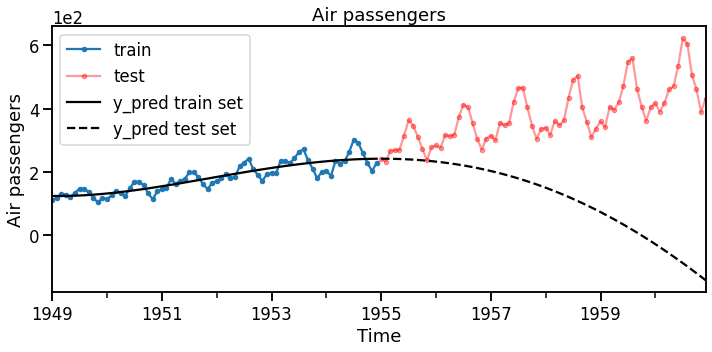

In [28]:
fig, ax = plt.subplots(figsize=[10, 5])

df_train[target].plot(ax=ax, marker='.')
df_test[target].plot(ax=ax, marker='.', color='r', alpha=0.4)

y_pred_train.plot(color='k', ax=ax)
y_pred_test.plot(color='k', ax=ax, linestyle='--')

ax.legend(["train", "test", "y_pred train set", "y_pred test set"])
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers")
ax.set_title("Air passengers")
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

In [29]:
model.coef_

array([[ -17.53511134,  431.24721937, -349.30511886,   53.08905756]])

In [30]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error
mean_squared_error(df_test[target], y_pred_test, squared=False)

320.4883941948673

In general, it is not recommended to use $t^2$ terms or higher. But, we can see that regularisation can help. In practice, it's best to experiment and see which features produce the best forecast for your own use case.

In the next notebook we'll show how the time feature helps in addition to adding lag features in a more complex example where we will use recursive forecasting.